In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import uuid #for generating guid code 
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [2]:
batch_size = 8
epochs = 200
threshold = 7000 #intensity of pixel to ignore
#number of depth images to keep, only a certain number contains the base gangli
zmin = 20
zmax = 30
#portion of image which contains the interested part of brain scan
xmin = 33
xmax = 162
ymin = 73
ymax = 202

deltaX = xmax-xmin
deltaY = ymax-ymin
deltaZ = zmax-zmin

img_size = deltaX+1

#during data augmentation the images will be shifted in the 4 directions of 5% and 10% of the width
shifting_percentages = [img_size*0.05, img_size*0.1]

background_percentage = 0.4

project_dir = os.getcwd()

data_folder = os.path.join(project_dir, 'CDOPA_dataset')
csv_path = os.path.join(project_dir, 'carbidopa.csv')

In [3]:
"""
DATA LOADING FUNCTIONS
"""

def load_scan(path):
    slices = [pydicom.read_file(os.path.join(path, s), force=True) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels(slices, rescale=False):
    if rescale:
        image = np.stack([s.pixel_array*(s.RescaleSlope*10) for s in slices])
        return np.array(image,dtype=np.float32)
    else:
        image = np.stack([s.pixel_array for s in slices])
        return np.array(image,dtype=np.int16)
    

def suv(slice, xmin, xmax, ymin, ymax):
    x = np.linspace(xmin, xmax, xmax-xmin+1)
    y = np.linspace(ymin, ymax, ymax-ymin+1)
    X,Y = np.meshgrid(x,y)
    Z = slice[X.astype(np.int),Y.astype(np.int)]
    return X,Y,Z


def slicecutoff(slice, threshold):
    slice[slice<threshold]=0.
    return slice

    
def create_dataset(data_folder, rescale=False, threshold=threshold):

    inumpatients = len(os.listdir(data_folder))#number of datapoints
    X_DATA = np.zeros([inumpatients, deltaX+1, deltaY+1, deltaZ])#initially 'empty dataset'
    patients = os.listdir(data_folder)#list all the folders containing the .dcm for each patient
    patients.sort()
    
    for num_patient, patient in enumerate(patients):
        patient_n = get_pixels(load_scan(os.path.join(data_folder, patients[num_patient])))

        #reference central slice and mask
        slice_central = patient_n[zmin+4]
        slice_centralcut = slice_central[xmin:xmax+1, ymin:ymax+1]

        if rescale:
            threshold_roi = slice_centralcut.max()*background_percentage
            threshold = threshold_roi

        mask_central = slicecutoff(slice_centralcut, threshold)

        for index, slice in enumerate(patient_n):
            if index in range(zmin,zmax):
                
                slicecut = slice[xmin:xmax+1, ymin:ymax+1]
                mask = slicecutoff(slicecut, threshold)

                #here it makes sure the larger portion of the mask is considered background
                #zeroing out the parts outsite the central region of interest
                if index < zmin + 4:
                    if (mask_central-mask).sum() > mask_central.sum():
                        slicecut[True] = 0.
                        mask[True] = 0.
                if index > zmin +4:
                    if abs((mask-mask_central)).sum() > mask_central.sum():
                        slicecut[True] = 0.
                        mask[True] = 0.
                
                X_DATA[num_patient,:,:,index-zmin] = slicecut
    
    return X_DATA
            

In [4]:
"""
DATA AUGMENTATION FUNCTIONS
"""

#shift param is how many pixel the image has to be shifted, 
# it has to be a signed flot for tanslation to the left or right
import uu


def shift_dataset(images, shift_param, axis='x'):
    
    if axis=='x':
        return tfa.image.translate(images, [shift_param,0])

    if axis=='y':
        return tfa.image.translate(images, [0, shift_param])

    else:
        raise Exception("Only x or y are valid axes")


def get_shifted_dataset(X_DATA, Y_D, Y_DATA, shifting_percentages):

    axes = ['x', 'y']

    augmented_dataset = X_DATA

    #augmented_dataset = np.zeros([2*len(shifting_percentages), img_size, img_size, deltaZ])

    for numpatient in range(len(X_DATA)):

        for shift_perc in shifting_percentages:

            for axis in axes:
            
                shifted_dataset = shift_dataset(X_DATA, shift_perc, axis=axis)
                augmented_dataset = np.append(augmented_dataset, shifted_dataset, axis=0)

                guid = uuid.uuid4()
                current_label = Y_DATA[numpatient]
                last_index = len(X_DATA)
                
                Y_D = np.append(Y_D, np.empty[1,2])
                Y_DATA = np.append(Y_DATA, np.empty[1,1])
                Y_D[last_index + numpatient, :] = (str(guid), current_label)
                Y_DATA[last_index + numpatient] = current_label

    return augmented_dataset, Y_D, Y_DATA
    

In [5]:
df_csv = pd.read_csv(csv_path)
df_csv['GUID']= df_csv['GUID'].astype(str)
df_sorted = df_csv.sort_values('GUID')
df_sorted = df_sorted.iloc[0:87,:]#in the csv there are more datapoints than in the CDOPA_dataset folder

Y_D = np.array(df_sorted[['GUID','LABEL']])
Y_DATA = np.array(df_sorted[['LABEL']])
X_DATA = create_dataset(data_folder)

In [6]:
X_DATA, X_DATA_TEST, Y_DATA, Y_DATA_TEST, Y_D, Y_D_TEST = train_test_split(X_DATA, Y_DATA, Y_D, test_size=0.30, random_state=21)

In [7]:
X_DATA_NEW, Y_D_NEW, Y_DATA_NEW = get_shifted_dataset(X_DATA, Y_D, Y_DATA, shifting_percentages=shifting_percentages)

TypeError: 'builtin_function_or_method' object is not subscriptable

'\nplt.subplot(1,2,1)\nplt.imshow(X_DATA[0,:,:,0])\nplt.subplot(1,2,2)\nplt.imshow(image_shifted[:,:,0])\n\nplt.show()\n'

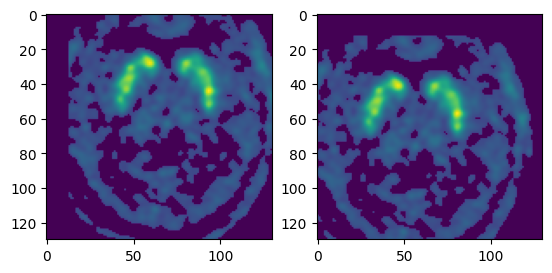

In [39]:
image = X_DATA[0,:,:,0]
augmented_images = np.zeros([2,img_size,img_size])
axes = ['x', 'y']

for index, axis in enumerate(axes):
    augmented_images[index] = shift_dataset(image, img_size*0.1, axis)



for index, trans_image in enumerate(augmented_images):

    plt.subplot(1,2,index+1)
    plt.imshow(trans_image)
    

